In [1]:
import mne
# %matplotlib inline
%matplotlib tk
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
data_path = r'../../static/eeg_data/panina1.set'

In [2]:
#Importing data and cropping for 
raw = mne.io.read_raw_eeglab(data_path, preload=True)
raw.crop(tmax=60).load_data()

Reading S:\MYFILES\programming\Python\Research work\Research work\cmd\eeg_processing\..\..\static\eeg_data\panina1.fdt
Reading 0 ... 46596  =      0.000 ...   465.960 secs...


<RawEEGLAB | panina1.fdt, 19 x 6001 (60.0 s), ~923 kB, data loaded>

## Низкочастотная фильтрация
применяется фильтр с конечной импульсивной характеристикой FIR
после применения фильтра, графики становятся менее "волнистыми"

In [3]:
# Убираем низкие частоты
raw_filtered_low_freq_drifts = raw.copy().filter(l_freq=1.,h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


In [3]:
# Построение графика исходных "сырых" данных
fig_raw = raw.plot(duration=30,remove_dc=False, title='Raw EEG Data')
fig_raw.suptitle("Raw data")

# Построение графика после применения низкочастотного фильтра
fig = raw_filtered_low_freq_drifts.plot(duration=30,remove_dc=False)
fig.suptitle("Filtered low frequency") 

Using matplotlib as 2D backend.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Text(0.5, 0.98, 'Filtered low frequency')

In [7]:
# Дополнительно можно построить PSD Спектральную мощность плотности

# PSD до фильтрации
spectrum = raw.compute_psd(fmax=5)  # Смотрим только низкие частоты
fig = spectrum.plot(average=True, picks="eeg")
fig.suptitle("Спектр мощности сигнала (PSD)")

# PSD после фильтрации
spectrum_filtered = raw_filtered_low_freq_drifts.compute_psd(fmax=5)
fig = spectrum_filtered.plot(average=True, picks="eeg")
fig.suptitle("Спектр мощности сигнала после применения фильтра (PSD)") 

Effective window size : 20.480 (s)
Plotting power spectral density (dB=True).
Effective window size : 20.480 (s)
Plotting power spectral density (dB=True).


Text(0.5, 0.98, 'Спектр мощности сигнала после применения фильтра (PSD)')

## Исследование наличия глазодвигательных артефактов

Effective window size : 20.480 (s)
Plotting power spectral density (dB=True).


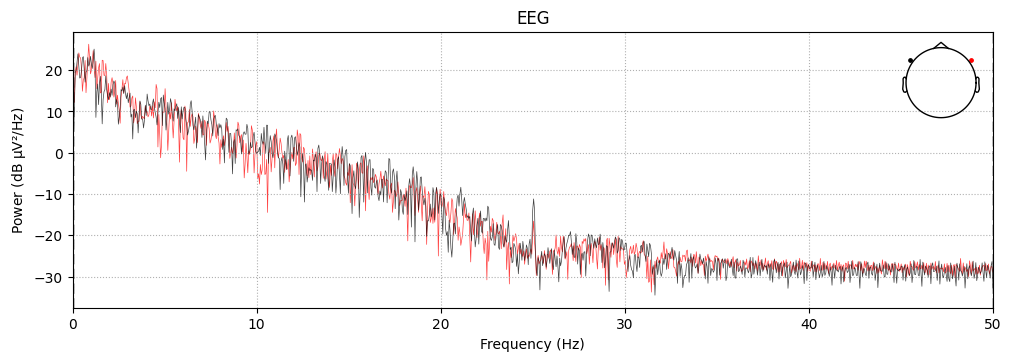

In [6]:
#Проведем анализ спектра мощности на фронтальных датчиках

spectrum = raw.compute_psd()
front_sensors = ["F7", "F8"]
spectrum.plot(picks=front_sensors, exclude="bads", amplitude=False)

In [8]:
# Как видно на графике, у нас имеется аномальный скачок сигнала, примерно на 25 ГЦ, попробуем применить метод Анализа Независимых Компонент ICA

ica = mne.preprocessing.ICA(max_iter="auto", random_state=97)
ica.fit(raw_filtered_low_freq_drifts)
explained_var_ratio = ica.get_explained_variance_ratio(raw_filtered_low_freq_drifts)
for channel_type, ratio in explained_var_ratio.items():
    print(f"Fraction of {channel_type} variance explained by all components: {ratio}")

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 18 components
Fitting ICA took 1.0s.
Fraction of eeg variance explained by all components: 1.0


In [9]:
explained_var_ratio = ica.get_explained_variance_ratio(
    raw_filtered_low_freq_drifts, components=[0], ch_type="eeg"
)
# This time, print as percentage.
ratio_percent = round(100 * explained_var_ratio["eeg"])
print(
    f"Fraction of variance in EEG signal explained by first component: "
    f"{ratio_percent}%"
)

Fraction of variance in EEG signal explained by first component: 49%


In [10]:
# Вывод независимых компонент. Из графика видно, что нет такой компоненты, которая бы отвечала за выявленный ранее аномальный скачок.
ica.plot_components()
# ica.plot_sources(raw_filtered_low_freq_drifts)
# Визуализация временных рядов ICA-компонент
ica_sources = ica.get_sources(raw_filtered_low_freq_drifts)

sources_data = ica_sources.get_data()

# Рассчитаем PSD для каждой компоненты
for component_idx in range(sources_data.shape[0]):
    fmin, fmax = 0.5, 50.0  # Пределы частот
    psds, freqs = mne.time_frequency.psd_array_welch(
        sources_data[component_idx, :], sfreq=ica_sources.info['sfreq'], fmin=fmin, fmax=fmax, n_fft=1024
    )

    # Построим график PSD
    plt.figure()
    plt.semilogy(freqs, psds, label=f'Component {component_idx}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD (Power/Frequency)')
    plt.title(f'PSD for ICA Component {component_idx}')
    plt.legend()
    plt.show()

Effective window size : 10.240 (s)
Effective window size : 10.240 (s)
Effective window size : 10.240 (s)
Effective window size : 10.240 (s)
Effective window size : 10.240 (s)
Effective window size : 10.240 (s)
Effective window size : 10.240 (s)
Effective window size : 10.240 (s)
Effective window size : 10.240 (s)
Effective window size : 10.240 (s)
Effective window size : 10.240 (s)
Effective window size : 10.240 (s)
Effective window size : 10.240 (s)
Effective window size : 10.240 (s)
Effective window size : 10.240 (s)
Effective window size : 10.240 (s)


C:\Users\Sergc.DESKTOP-TU3FSM6\AppData\Local\Temp\ipykernel_15252\74812914.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Effective window size : 10.240 (s)
Effective window size : 10.240 (s)


## Применение полосно-заграждающего фильтра
Попробуем применить фильтр Нотча, чтобы попробовать вырезать частоту, на которой заметен скачок

In [12]:
# PSD после фильтрации
spectrum_filtered = raw_filtered_low_freq_drifts.compute_psd(fmin=24, fmax=26)
fig = spectrum_filtered.plot(average=True, picks="eeg")
fig.suptitle("Спектр мощности сигнала после применения фильтра (PSD)") 

copy_raw = raw_filtered_low_freq_drifts.copy()

Effective window size : 20.480 (s)
Plotting power spectral density (dB=True).


In [14]:
# Частоты, которые вы хотите убрать (например, 50 Гц и гармоники)
freqs = [25.07]

# Применение фильтра Нотча
copy_raw.notch_filter(freqs=freqs, picks='all', method='fir',trans_bandwidth=0.05)
spectrum_filtered = copy_raw.compute_psd(fmin=24, fmax=26)
fig = spectrum_filtered.plot(average=True, picks="eeg")
fig.suptitle("Спектр мощности сигнала после применения фильтра (PSD)") 

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 25 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 24.98
- Lower transition bandwidth: 0.03 Hz (-6 dB cutoff frequency: 24.97 Hz)
- Upper passband edge: 25.16 Hz
- Upper transition bandwidth: 0.03 Hz (-6 dB cutoff frequency: 25.17 Hz)
- Filter length: 13201 samples (132.010 s)
Effective window size : 20.480 (s)
Plotting power spectral density (dB=True).


C:\Users\Sergc.DESKTOP-TU3FSM6\AppData\Local\Temp\ipykernel_15576\1043867088.py:5: RuntimeWarning: filter_length (13201) is longer than the signal (6001), distortion is likely. Reduce filter length or filter a longer signal.
  copy_raw.notch_filter(freqs=freqs, picks='all', method='fir',trans_bandwidth=0.05)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Text(0.5, 0.98, 'Спектр мощности сигнала после применения фильтра (PSD)')